In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# **Implement a convultional neural network to denoise multivariate signals using synthetic data**

## Introduction
In today's data-driven world, the importance of multivariate data analysis spans across industries. However, real-life signals are often contaminated with noise, hindering accurate interpretation and decision-making.

Traditional noise removal methods applied on time-series, like box-car averaging, distort the true signal due to temporal and/or spatial overlap with noise. To overcome this limitation, I explore the use of convolutional neural networks (CNNs) for denoising multivariate signals.

In this notebook I show how the random combination of recorded noise with synthetic signal components allows the construction of a large training set, enabling robust training of a CNN-based model. The resulting CNN effectively removes noise, while preserving signal integrity.

I illustrate this approach on fluorescence measurements of brain activity, though it can be generalised to various signal types.

## Dataset
In this project, I implement a CNN-based model to denoise fluorescence recordings of brain activity. Namely, from a genetically-encoded fluorescence reporter (iAChSnFR), used to probe the neuromodulator acetylcholine (ACh) in the brain.
Data used to generate training and test datasets were acquired from optic fibers implanted in the brain of freely-moving mice or recorded ex-vivo. The fluorescence signal was measured using a spectrometer, generating multivariate data, where each sample consists in a vector of light intensities over a wavelength range (spectral resolution of 0.5 nm), in this case from 480 to 600 nm.

## Approach
To achieve my goal, the CNN was trained on synthetic data containing a mixture of feautres derived from biological signals and noise. In order to adecquately model these components, it is important to understand their specific spectral and temporal features.


### Spectral signatures of biological signals
From previous data on the iAChSnFR reporter, the effect of ACh on fluorescence emission is shown below (orange traces). In addition to ACh, in vivo fluorescence is modulated by light absorption by hemoglobin. The latter is present as a mixture of oxygen-bound (HbO2) and oxygen-unbound (Hb) forms. The expected spectral effect on fluorescence, given an arbitrary amount of each hemoglobin form, is shown in the right plot below.

<img src="http://drive.google.com/uc?export=view&id=1CxpoJ-uOdtQ2lPki16WVIprAmi65Ybsy" width=800>

**Left:** Emission spectrum of iAChSnFR excited at 440 nm without (Apo) and with ACh in the medium. **Rigth:** Relative spectral effect of arbitrary concentrations of ACh, HbO2 and Hb on fluorescence.




### Temporal signatures of biological signals
In addition to characteristic spectral features, some assumptions can be made about ACh's and hemodynamics' temporal profiles.


#### Acetylcholine
Simillarly to other fluorescence reporters, iAChSnFR response to its binding molecule (ACh) seems to be convoluted with an exponential decay kernel. As a result, the ACh component has a stereotipic profile consisting of a sharp rise and an exponential decay. Such dynamics can be fitted with an appropriate convolution model, which I use to generate synthetic ACh temporal dynamics.

<img src="http://drive.google.com/uc?export=view&id=1DlAWbbw_JsOYi3k4UG8OmgjuiJzZeUBI" width=600> <br>
Example of a fitting of an exponential convolution model to the in vivo temporal profile of ACh derived from iAChSnFR fluorescence.
<br></br>

#### Hemodynamics
The hemodynamic component of the signal is limitted in its frequency content due to the low-pass filtering effect of vascular and oxygen exchanging dynamics. It is therefore reasonable to assume no energy in the hemodynamic signal at time-scales under 1 second.
<br></br>

#### Building synthetic time series
To generate synthetic temporal dynamics of ACh, HbO2 and Hb I followed these steps:

**1 -** Fitted the raw data (one recording session) with a model that accounts for spectral contributions of ACh, HbO2 and Hb, taking into accout the spectral features presented above.

**2 -** Fitted the time-series of ACh level with a convolution model (exponential decay with appropriate time-constant). The result was used to build the ACh synthetic component, modeled as a change in the intensity of the ACh spectral signature over time.

**3 -** Low-pass filtered the hemodynamic components obtained in point **1**. The resulting time-series was used to build the synthetic HbO2 and Hb components, taking into account the corresponding spectral signatures.

Below I show a short segment of synthetic biological signals and their combination.

<center>

<img src="http://drive.google.com/uc?export=view&id=1AfPPjhrbpwl8d0ZqlyzGzTpJ5OXmKUjq">
<center/>
Segment of synthetic data showing the temporal profile of intensities of different components (top), the respective individual spectral patterns (middle) and their mixture (bottom).


### **Noise**
Two main sources of instrumental noise affect fluorescence recordings: dark noise and shot noise.<br><br>

#### Dark noise
Dark noise arises from the random electrical signal generated by the detector in the absence of light. It can introduce a baseline signal even when there is no fluorescence present. It can be described by the equation:

<center>
$S_{\text{dark}} \propto \sqrt{I_{\text{dark}}}$,
</center>


where $S_{\text{dark}}$ is the standard deviation of the noise, and $I_{\text{dark}}$  is the dark current (current generated in the absence of light).
<br><br>
#### Shot noise
Shot noise is the result of the statistical nature of photon arrivals in a light signal. It occurs due to the discrete nature of light and can be described by Poisson statistics. Shot noise is proportional to the square root of the average number of photons detected, as shown in the following equation:

<center>
$S_{\text{shot}} \propto \sqrt{I_{\text{signal}}}$,
</center>


where $S_{\text{shot}}$ is the standard deviation of the noise, and $I_{\text{signal}}$  is the signal current generated by the fluorescence photons at the detector.
<br><br>
#### Noise acquisition for training
Dark and shot noise were obtained experimentally by measuring light emitted from a broadband light-emiting diode with a spectrometer. This was accomplished using a protocol that involved 190 ms light pulses interleaved with dark periods of equal duration.  The shot noise was acquired from the light-on pulses while dark noise was recorded during light-off pulses.




## Outline
The implementation and training of the neural network model is organized as follows:



*   Create the dataset used to generate training instances
*   Define the neural network model
*   Define the training function
*   Define auxiliary functions
*   Train
*   Visually check results







## **Create dataset to generate training instances**
The building blocks of the training dataset were generated in Matlab. Those are synthetic time-series representing the biological signals (ACh, Hb and HbO2) and recorded noise. Acetylcholine and hemodynamics can be physiologically correlated under certain conditions, which could bias the denoising model. To decorrelate the signals, the time points used to build the ACh component, hemodynamic segments and noise were independently ascribed.

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat

Load data to build training instances

In [2]:
#load data from mat files
data_origin = loadmat('../../../data/Denoising/noise_components_dataset_slowHb.mat')

Set the device to work on: GPU or CPU

In [3]:
dev = torch.device("cuda:0")

### Create the training dataset

Define the dataset class, which creates instances by randomly mixing different components of the signal. Namely, ACh, hemodynamics and shot and dark noise.

In [7]:
class GenerateData(Dataset):
    """
    Generates training instances from provided signal components.
    
    Inputs:
    - HbO2 (1D array): Time-series of oxy-hemoglobin absorption intensity
    - HbO2_spec (1D array): Spectral profile of oxy-hemoglobin absorption
    - Hb (1D array):Time-series of deoxy-hemoglobin absorption intensity
    - Hb_spec (1D array): Spectral profile of deoxy-hemoglobin absorption
    - ACh (1D array): Time-series of ACh extracellular level
    - ACh_spec (1D array): Spectral profile of ACh effect in fluorescence emission
    - Emission_spec (1D array): Average fluorescence emission spectrum upon which ACh, Hb and HbO2 exert an effect
    - dark_spectra (2D array): Time-series of recorded dark noise
    - shot_spectra (2D array): Time-series of recorded shot noise
    - indices_signals: Indices in the time-series of biological signal that can be sampled
    - indices_noise: Indices in the time-series of recorded noise that can be sampled

    The wavelength range used in all signal components was 480-595 nm.
    """
    def __init__(self, HbO2,HbO2_spec,Hb,Hb_spec,ACh,ACh_spec,Emission_spec,dark_spectra,shot_spectra,indices_signals,indices_noise):
        self.HbO2 = HbO2
        self.HbO2_sp = HbO2_spec
        self.Hb = Hb
        self.Hb_sp = Hb_spec
        self.ACh = ACh
        self.ACh_sp = ACh_spec
        self.Emission_sp = Emission_spec
        self.dark_sp = dark_spectra
        self.shot_sp = shot_spectra
        self.indsig = indices_signals
        self.indnoise = indices_noise

    # We define the length of the dataset as 1000, which does not have a real meaning
    # giving the very large number different instances that can be generated
    # This is relevant only for tracking the extent of training (1 epoch = 1000 instances)
    def __len__(self):
        return 1000

    def __getitem__(self, index):
        window_instance = 5  #half-window size in seconds
        SampRate = 5  #sampling rate
        
        # Shuffle indices to sample
        index_Hb = self.indsig[torch.randint(0,len(self.indsig),(1,))]
        index_ACh = self.indsig[torch.randint(0,len(self.indsig),(1,))]
        index_noise = self.indnoise[torch.randint(0,len(self.indnoise),(1,))]
        index_exnoise = self.indnoise[torch.randint(0,len(self.indnoise),(1,))]

        # Lambda function to generate indices of instance windows
        windf = lambda a: range(a - window_instance * SampRate, a + window_instance * SampRate + 1)

        #biological component
        exp_term = torch.matmul(-self.HbO2[windf(index_Hb)],torch.transpose(self.HbO2_sp,0,1))+torch.matmul(-self.Hb[windf(index_Hb)],
                      torch.transpose(self.Hb_sp,0,1))+torch.matmul(self.ACh[windf(index_ACh)],torch.transpose(self.ACh_sp,0,1))
        
        #biological components exert a multiplicative effect on emission, modeled as an exponential term
        Full_exp = torch.exp(exp_term)
        clean = Full_exp * torch.tile(torch.transpose(self.Emission_sp,0,1), (Full_exp.size(dim=0), 1))

        #noise components
        noise_dark = self.dark_sp[windf(index_noise),:]
        noise_shot = self.shot_sp[windf(index_noise),:]

        #the shot noise in emission is wavelength-dependent, scaling with the square root
        #of intensity at each wavelength
        noise_shot = noise_shot / torch.sqrt(torch.mean(noise_shot, dim=0, keepdim=True) / torch.mean(clean, dim=0, keepdim=True))
        noise_shot = noise_shot-torch.mean(noise_shot,dim=0,keepdim=True)


        #shot noise is scaled by a factor (used either 0.3 or 0.8)
        rand_shot = 0.3
        noise = noise_dark+rand_shot*noise_shot

        X = clean.unsqueeze(0)
        y = noise.unsqueeze(0)
        
        return X, y

Instantiate dataset object

In [5]:
#Create datasets

#clean data (biological signals)
data_oxyhb = torch.tensor(data_origin['OxyHb'],dtype=torch.float,device=dev)
data_hb = torch.tensor(data_origin['Hb'],dtype=torch.float,device=dev)
data_hbabs = torch.tensor(data_origin['Hb_absorption'],dtype=torch.float,device=dev)
data_oxyhbabs = torch.tensor(data_origin['OxyHb_absorption'],dtype=torch.float,device=dev)
data_ACh = torch.tensor(data_origin['ACh_dynamics'],dtype=torch.float,device=dev)
data_ACh_spec = torch.tensor(data_origin['ACh_spectrum'],dtype=torch.float,device=dev)
data_Emission = torch.tensor(data_origin['Emission_average'],dtype=torch.float,device=dev)
data_dark_spectra = torch.tensor(data_origin['dark_spectra'],dtype=torch.float,device=dev)
data_shot_spectra = torch.tensor(data_origin['shot_spectra'],dtype=torch.float,device=dev)

indices_to_sample = torch.arange(10*5+100,len(data_oxyhb)-10*5-10)
indtrain_signals,indval_signals = random_split(indices_to_sample,[0.8,0.2])
print(len(indtrain_signals))

indices_to_sample = torch.arange(10*5,len(data_dark_spectra)-10*5)
indtrain_noise,indval_noise = random_split(indices_to_sample,[0.8,0.2])

# Create trainset object
trainset = GenerateData(data_oxyhb,data_oxyhbabs,data_hb,data_hbabs,data_ACh,data_ACh_spec,
                        data_Emission,data_dark_spectra,data_shot_spectra,indtrain_signals,indtrain_noise)

35157


## CNN for denoising

For this application a chose a denoising CNN architecture (DnCNN) that has been already developed, showing good denoising performance. For details on the model design please refer to the original researh article (Zhang K, Zuo W, Chen Y, Meng D, Zhang L. Beyond a gaussian denoiser: Residual learning of deep cnn for image denoising. *IEEE Transactions on Image Processing. 2017*) or to the detailed blog post at: https://sh-tsang.medium.com/review-dncnn-residual-learning-of-deep-cnn-image-denoising-super-resolution-jpeg-deblocking-cbf464b03130.

Briefly, the model consists in a deep convolutional neural network (17-20 layers) which implements residual learning using batch normalization to improve performance. The model implicitly learns to remove the latent image (or biological signal, in the context of this project) and outputs the noise (residual).

![DnCNN architecture](https://miro.medium.com/v2/resize:fit:2000/format:webp/1*Z0Qc0-ixlMKKs8EnPN3Z-Q.png)

The code below for the DnCNN class implementation was extracted from the opendenoising package: https://opendenoising-docs.readthedocs.io/en/latest/_modules/model/architectures/pytorch/dncnn.html

In [5]:
!git clone https://github.com/SaoYan/DnCNN-PyTorch

Cloning into 'DnCNN-PyTorch'...
remote: Enumerating objects: 583, done.
remote: Total 583 (delta 0), reused 0 (delta 0), pack-reused 583
Receiving objects: 100% (583/583), 31.67 MiB | 22.85 MiB/s, done.
Resolving deltas: 100% (47/47), done.
Updating files: 100% (491/491), done.


In [17]:
from DnCNN_PyTorch.models import DnCNN

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class DnCNN(nn.Module):
  def __init__(self, depth=17, n_filters=64, kernel_size=3, n_channels=1,padding=1):
        """Pytorch implementation of DnCNN. Implementation followed the original paper [1]_. Authors original code can be
        
        Parameters
        ----------
        depth : int
            Number of fully convolutional layers in dncnn. In the original paper, the authors have used depth=17 for non-
            blind denoising and depth=20 for blind denoising.
        n_filters : int
            Number of filters on each convolutional layer.
        kernel_size : int tuple
            2D Tuple specifying the size of the kernel window used to compute activations.
        n_channels : int
            Number of image channels that the network processes (1 for grayscale, 3 for RGB)

        """
        super(DnCNN, self).__init__()
        layers = [
            nn.Conv2d(in_channels=n_channels, out_channels=n_filters, kernel_size=kernel_size,
                      padding=padding, bias=False),
            nn.ReLU(inplace=True)
        ]
        for _ in range(depth-2):
            layers.append(nn.Conv2d(in_channels=n_filters, out_channels=n_filters, kernel_size=kernel_size,
                                    padding=padding, bias=False))
            layers.append(nn.BatchNorm2d(n_filters))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(in_channels=n_filters, out_channels=n_channels, kernel_size=kernel_size,
                                padding=padding, bias=False))
        self.dncnn = nn.Sequential(*layers)


  def forward(self, x):
    out = self.dncnn(x)
    return out

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class DnCNN(nn.Module):
  def __init__(self, depth=17, n_filters=64, kernel_size=3, n_channels=1,padding=1):
        """Pytorch implementation of DnCNN. Implementation followed the original paper [1]_. Authors original code can be
        
        Parameters
        ----------
        depth : int
            Number of fully convolutional layers in dncnn. In the original paper, the authors have used depth=17 for non-
            blind denoising and depth=20 for blind denoising.
        n_filters : int
            Number of filters on each convolutional layer.
        kernel_size : int tuple
            2D Tuple specifying the size of the kernel window used to compute activations.
        n_channels : int
            Number of image channels that the network processes (1 for grayscale, 3 for RGB)

        """
        super(DnCNN, self).__init__()
        layers = [
            nn.Conv2d(in_channels=n_channels, out_channels=n_filters, kernel_size=kernel_size,
                      padding=padding, bias=False),
            nn.ReLU(inplace=True)
        ]
        for _ in range(depth-2):
            layers.append(nn.Conv2d(in_channels=n_filters, out_channels=n_filters, kernel_size=kernel_size,
                                    padding=padding, bias=False))
            layers.append(nn.BatchNorm2d(n_filters))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(in_channels=n_filters, out_channels=n_channels, kernel_size=kernel_size,
                                padding=padding, bias=False))
        self.dncnn = nn.Sequential(*layers)
        self.fc1 = nn.Linear(152*51,51)

  def forward(self, x):
    out = self.dncnn(x)
    out = out.view(-1,152*51)
    out = self.fc1(out)
    return out



## Generating training instances
In order to maximize the number of possible training instances while minimizing computational resources, the training instances are generated during the training process by randomly combining the different dataset components. Namely, biological signals, dark noise, shot  noise in emission and shot noise in excitation. Let's have a look at examples of single generated instances.

In [14]:
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import RandomSampler
#wavelength and time axis
wavelength = np.arange(476.924,595.404,0.7846)
time = np.arange(0,20.2,0.2)

#function to plot training instances
def plot_instances(data, wavelength, time, batch_size=3):

  loader = iter(DataLoader(data,batch_size=batch_size))

  fig, axs = plt.subplots(batch_size, 3, figsize=(8, 8))

  # Adjust the spacing between subplots
  plt.subplots_adjust(hspace=0.4,wspace=0.4)

  # Get a single batch of data
  clean, noise = next(loader)

  print(clean.size())
  #the sample is the sum of the clean and noise components
  sample = clean+noise
  #sample = clean
    
  AChspec = torch.abs(data_ACh_spec).squeeze()
  AChspec = AChspec.unsqueeze(0).unsqueeze(0).unsqueeze(0)
    
  #sample = sample*AChspec

  #squeeze, normalize and transpose for plotting
  def trans_plot(a,i):
    trans = torch.squeeze(a[i,:,:,:])
    trans = trans-torch.mean(trans,dim=0,keepdim=True)
    trans = trans.T.cpu()
    return torch.flipud(trans)

  #wavelength = np.flipud(wavelength)
  axis_lims = [time[0],time[-1],wavelength[0], wavelength[-1]]

  for i in range(batch_size):

    clean_plot = trans_plot(clean,i)
    noise_plot = trans_plot(noise,i)
    sample_plot = trans_plot(sample,i)

    # Plot clean, noise, and sample
    axs[i, 0].imshow(clean_plot, aspect='auto', cmap='viridis',extent=axis_lims)
    axs[i, 0].set_ylabel("Wavelength (nm)")
    axs[i, 0].set_xlabel("Time (s)")
    axs[i, 0].set_title("Clean")

    axs[i, 1].imshow(noise_plot, aspect='auto', cmap='viridis',extent=axis_lims)
    axs[i, 1].set_ylabel("Wavelength (nm)")
    axs[i, 1].set_xlabel("Time (s)")
    axs[i, 1].set_title("Noise")

    axs[i, 2].imshow(sample_plot, aspect='auto', cmap='viridis',extent=axis_lims)
    axs[i, 2].set_ylabel("Wavelength (nm)")
    axs[i, 2].set_xlabel("Time (s)")
    axs[i, 2].set_title("Sample")

  plt.tight_layout()
  plt.show()

torch.Size([3, 1, 101, 152])


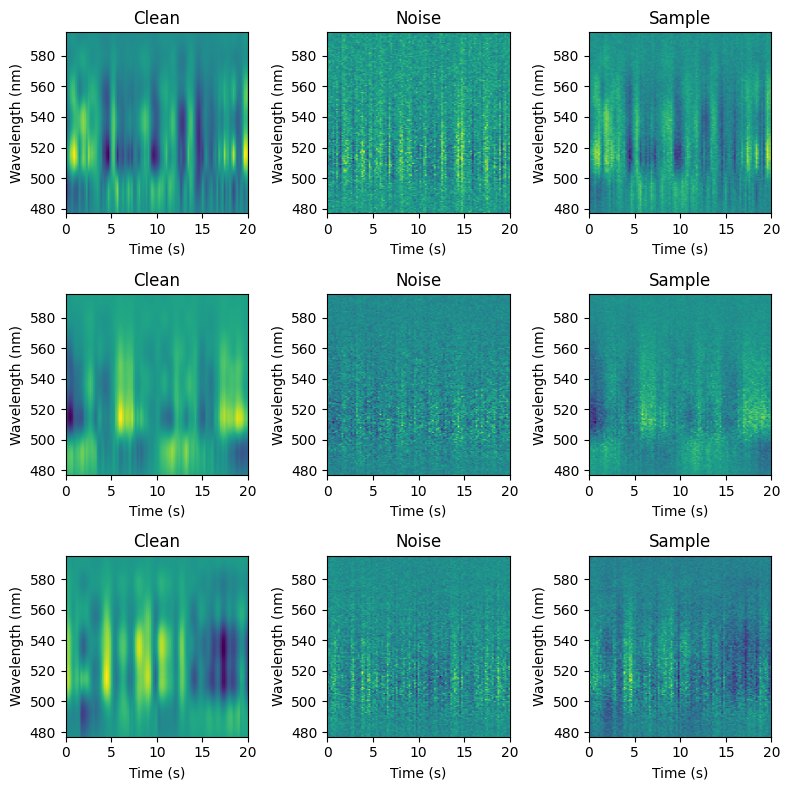

In [15]:
plot_instances(trainset,wavelength,time)

## Training function
The training function generates training instances for each batch and then calculates the loss and updates the weigths based on backpropagation. Epochs here are defined considering the original number of training instaces generated in Matlab for each signal component (1000).

In [7]:
wavelength_origin = loadmat('../../../data/Denoising/wavelength.mat')
wavelength = torch.tensor(wavelength_origin['wavelengthT'],device=dev)

In [48]:
import numpy as np
from scipy.optimize import curve_fit

def fit_ACh_spectra(yspec, wavelengthT, sw=None, starting_wl=None, AChefnorm=None, Hb=None, HbO2=None):
    # Assumes the standard wavelength vector from 350 to 1000 nm from spectrometer data
    
    
#     # Create arrays to be concatenated
#     first_part = np.tile(yspec[:, 0].reshape(-1, 1), 10)
#     last_part = np.tile(yspec[:, -1].reshape(-1, 1), 201 - 152 - 10)

#     # Concatenate the arrays along the second dimension (axis=1)
#     yspec = np.concatenate((first_part, yspec, last_part), axis=1)
    
    
    # Perform hemodynamic fitting
#     if sw is None:
#         sw = np.arange(210, 311)
    
    #ACh_pad = 139 - starting_wl
    
    # Check zeros in the beginning
#     ind = np.sum(yspec, axis=1)[::-1] == 0
#     difind = np.argmax(np.diff(ind) == 1)
#     difind = yspec.shape[0] - difind + 1 if difind is not None else 0
    
#     if difind:
#         BegPad = difind
#     else:
#         BegPad = 0
    
#     ind_negative = np.sum(yspec, axis=1) < 0
#     if np.any(ind_negative):
#         yspec[ind_negative] = np.zeros((np.sum(ind_negative), yspec.shape[1]))
    
    #print(type(yspec))
    
    #neutralinvivo = np.mean(yspec[BegPad + 2: BegPad + 2 + round(yspec.shape[0] * 0.8), sw], axis=0)
    #neutralinvivo = torch.tile(torch.mean(yspec, dim=0),(51,1))
    #neutralinvivo = torch.transpose(neutralinvivo,0,1)
    
    neutralinvivo = np.mean(yspec, axis=0)
    #sig_n = yspec[:, sw] / neutralinvivo.reshape(1, -1)
    sig_n = yspec / neutralinvivo.reshape(1, -1)
    
    #AChefnorm = AChefnorm[sw - ACh_pad]
    
    # Interpolate with wavelength vector
#     HbInterp = np.interp(wavelengthT, Hb[50:, 0], Hb[50:, 1]) / 1e6
#     HbO2Interp = np.interp(wavelengthT, HbO2[50:, 0], HbO2[50:, 1]) / 1e6
    
#     HbInterp = HbInterp[sw]
#     HbO2Interp = HbO2Interp[sw]

    AChefnorm = AChefnorm.reshape(-1,152)
    HbInterp = Hb.reshape(-1,152)
    HbO2Interp = HbO2.reshape(-1,152)
    
#     def mF(x, m1):
#         return 1. * np.exp(m1[0] - x[:, 0] * m1[1] - x[:, 1] * m1[2] + x[:, 2] * m1[3]) + m1[4] / neutralinvivo
    
#     def mF(x, m):
#         offset1 = torch.ones((152,1),device=dev)
#         #print(offset1.size())
#         return 1. * torch.exp(torch.matmul(offset1,m[0,:].unsqueeze(0)) - torch.matmul(x[:, 0].unsqueeze(1), m[1,:].unsqueeze(0)) 
#             - torch.matmul(x[:, 1].unsqueeze(1),m[2,:].unsqueeze(0)) + torch.matmul(x[:, 2].unsqueeze(1), m[3,:].unsqueeze(0))) + torch.matmul(offset1,m[4,:].unsqueeze(0)) / neutralinvivo
    
    def mF(x, m1, m2, m3, m4, m5):
        return 1. * np.exp(m1 - x[0,:] * m2 - x[1,:] * m3 + x[2,:] * m4) + m5 / neutralinvivo
    
    #yfity = torch.transpose(sig_n,0,1)
    
    yfity = sig_n
    
    mfit = np.zeros((yfity.shape[0], 5))
    Ly = yfity.shape[0]
    
    # Filter
    #yfity[np.isnan(yfity)] = 0
    
    # Fit the model
    for i in range(Ly):
        if np.sum(yfity[i]) > 0:
            #print(np.shape(np.concatenate((HbO2Interp, HbInterp, AChefnorm),axis=1))
            input_data = np.concatenate((HbO2Interp, HbInterp, AChefnorm),axis=0)
            #print(np.shape(input_data))
            popt, _ = curve_fit(mF, input_data, yfity[i], p0=[0.1, 0.1, 0.1, 0.1, 1])
            mfit[i] = popt
    
#     input_data = torch.stack([HbO2Interp, HbInterp, AChefnorm], dim=1)
#     #popt = torch.tensor([0.1, 0.1, 0.1, 0.1, 1], dtype=torch.float32, requires_grad=True,device='cuda:0')
#     vals = torch.tensor([0.1, 0.1, 0.1, 0.1, 1], dtype=torch.float32,device='cuda:0')
#     popt = torch.tensor(torch.tile(vals.unsqueeze(1),(1,51)),requires_grad=True)
#     optimizer = torch.optim.Adam([popt], lr=0.01)
    
#     #for i in range(Ly):
#         #if torch.sum(yfity[i]) > 0:
    
#     #print((input_data.size(),yfity.size()))
    
#     for p in range(100):  # 500 iterations (adjust as needed)
#         print(p)
#         #print(popt.size())
#         #print(np.shape(mF(input_data, popt)))
#         optimizer.zero_grad()
#         loss = torch.sum((mF(input_data, popt) - yfity) ** 2)
#         loss.backward()
#         optimizer.step()

#     mfit = popt
    
    
    # Subtract hemodynamics from the data
#     Fulltest = mfit[:, 0] - mfit[:, 1] * HbO2Interp - mfit[:, 2] * HbInterp + mfit[:, 3] * AChefnorm
#     Fullfit = np.exp(Fulltest) + mfit[:, 4] * (0.5 * np.arange(1, len(sw) + 1) + 30) / neutralinvivo.reshape(1, -1)
    
#     Hbtest = -mfit[:, 1] * HbO2Interp - mfit[:, 2] * HbInterp
#     Hbfit = np.exp(Hbtest)
#     sig_Hbc = sig_n * np.exp(-Hbtest)
#     AChfit = mfit[:, 4] * (0.5 * np.arange(1, len(sw) + 1) + 30) / neutralinvivo.reshape(1, -1)
    
    return mfit[:,3]


In [59]:
#create torch extension to use fitting function
from torch.autograd import Function

class FittingACh(Function):
    @staticmethod
    def forward(ctx, outputs, target, criterion):
        
        def fit(sample):
            AChspec = data_ACh_spec.cpu().numpy().squeeze()
            Hbspec = data_hbabs.cpu().numpy().squeeze()
            HbO2spec = data_oxyhbabs.cpu().numpy().squeeze()
            fitbatch = torch.zeros((len(sample),1,51),device='cuda:0')

            for i in range(len(sample)):
                samp = sample[i,:,:,:].squeeze()
                fitbatch[i,0,:] = torch.from_numpy(fit_ACh_spectra(samp,wavelength,
                    AChefnorm=AChspec,Hb=Hbspec, HbO2=HbO2spec))
            return fitbatch.to('cuda:0')
        
        outputs, target = outputs.detach().cpu().numpy(), target.detach().cpu().numpy()
        y_pred, y = fit(outputs), fit(target)
        result = criterion(y_pred, y)
        ctx.save_for_backward(y_pred, y)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        #print(grad_output.size())
        y_pred, y = ctx.saved_tensors
        print(y.size())
        grad_input = None
        
        grad_input = 2*(y_pred-y)/y_pred.shape[0]
        return grad_input, None, None
    
        

In [63]:
from torch.utils.data.dataloader import RandomSampler
from scipy.ndimage import gaussian_filter

# def gaussian_filter_torch(input, sigma):
#         # Create 1D Gaussian kernel
#         sigma = torch.tensor(sigma,device='cuda:0')
#         size = int(2 * 4 * sigma + 1)  # Adjust the multiplier (4) for desired kernel size
#         kernel = torch.tensor([[torch.exp(-0.5 * ((x-size)**2 + (y-size)**2) / sigma**2)
#                             for y in range(size * 2 + 1)] for x in range(size * 2 + 1)],device='cuda:0')
#         kernel = kernel / kernel.sum()

#         # Expand kernel to 2D
#         kernel = kernel.view(1, 1, size * 2 + 1, size * 2 + 1)

#         # Apply convolution using the Gaussian kernel
#         output = F.conv2d(input, kernel, padding=size)

#         return output

def trainNet(net, data_train, optimizer,criterion, batch_size=10, epochs=4, lossind=1, printr=False, save_loss=False):
    """Function to train the neural network
        Inputs:
            net: network to train
            batch_size: size of the mini-batch used in the SGD optimization
            epochs: number of traning epochs
            epoch start: number of epochs run so far + 1. Used to keep track of total training
                epochs when the function takes an already pretrained network as input
            printr: boolean to determine whether running loss is displayed during execution
            save_loss: boolean used to indicate wheter to store information about the running loss"""


    loader = DataLoader(data_train,batch_size=batch_size)

    #train
    import time
    start = time.time()
    #global loss
    epoch_start = 0
    rloss = []
    sclist = [3, 0.02, 1]
    ind=2
    sc = sclist[ind]
    AChspec = torch.abs(data_ACh_spec).squeeze()
    AChspec = AChspec.unsqueeze(0).unsqueeze(0).unsqueeze(0)
    lossfit = FittingACh.apply
    
    def smooth_batch(sample):
        smbatch = torch.zeros((len(sample),1,101,152),device='cuda:0')
        for i in range(len(sample)):
            smbatch[i,0,:,:] = torch.from_numpy(gaussian_filter(sample[i,:,:,:].cpu().squeeze(),sigma=(2,2))).to('cuda:0')
            #smbatch[i,0,:,:] = sample[i,:,:,:].cpu().squeeze().to('cuda:0')
        return smbatch
    
#     def fit_batch(sample):
#         with torch.no_grad():
#             fitbatch = torch.zeros((len(sample),1,51),device='cuda:0')
#             for i in range(len(sample)):
#                 samp = sample[i,:,:,:].clone().detach().cpu().numpy().squeeze()
#                 fitbatch[i,0,:] = torch.from_numpy(fit_ACh_spectra(samp,wavelength,
#                     AChefnorm=data_ACh_spec.cpu().numpy().squeeze(),Hb=data_hbabs.cpu().numpy().squeeze(),
#                     HbO2=data_oxyhbabs.cpu().numpy().squeeze())).to('cuda:0')
#         return fitbatch
    
#     def fit_batch(sample):
#         fitbatch = torch.zeros((len(sample),1,51),device='cuda:0')
#         for i in range(len(sample)):
#             fitbatch[i,0,:] = fit_ACh_spectra(sample[i,:,:,:].squeeze(),wavelength,
#                 AChefnorm=data_ACh_spec,Hb=data_hbabs,
#                 HbO2=data_oxyhbabs)
#         return fitbatch
    
#     def smooth_batch(sample):
#         smbatch = gaussian_filter_torch(sample,sigma=1)
#         return smbatch

#     def fit(sample):
#         sample = sample.detach().cpu().numpy()
#         AChspec = data_ACh_spec.cpu().numpy().squeeze()
#         Hbspec = data_hbabs.cpu().numpy().squeeze()
#         HbO2spec = data_oxyhbabs.cpu().numpy().squeeze()
#         fitbatch = torch.zeros((len(sample),1,51),device='cuda:0')

#         for i in range(len(sample)):
#             samp = sample[i,:,:,:].squeeze()
#             fitbatch[i,0,:] = torch.from_numpy(fit_ACh_spectra(samp,wavelength,
#                 AChefnorm=AChspec,Hb=Hbspec, HbO2=HbO2spec))
#         return fitbatch.to('cuda:0')

    for epoch in range(epochs):  # loop over the dataset multiple times

        epoch_start += 1
        running_loss = 0.0

        #scaling factor for noise
        if (epoch+1) % 100 == 0:
          ind=2
          sc = sclist[ind]

        
        for i, (clean,noise) in enumerate(loader):

            #the sample is the sum of the clean and noise components
            sample = clean+noise
            #sample = clean

            # zero the parameter gradients
            optimizer.zero_grad()
            
            #netsm = smooth_batch(sample)
            #print(netsm.size())
            #compute network output
            outputs=net(sample)
            
            #fitsample = torch.tensor(fit_batch(sample-outputs),device=dev)
            #fitclean = torch.tensor(fit_batch(clean),device=dev)
            
#             fitsample = fit_batch(sample-outputs)
#             fitclean = fit_batch(clean)
            
            #calculate loss
            if lossind==1:
                loss = criterion(outputs, noise)
            if lossind==2:
                loss = criterion(torch.diff(outputs,dim=2),torch.diff(noise,dim=2))
            if lossind==3:
                loss = criterion(torch.diff(outputs,dim=2)*AChspec,torch.diff(noise,dim=2)*AChspec)
            if lossind==4:
                loss = criterion(outputs*AChspec, noise*AChspec)
            if lossind==5:
                 loss = criterion(outputs, fit(clean))
                
            #loss = criterion(outputs, noise)
            #loss = criterion(fitsample-torch.mean(fitsample),fitclean-torch.mean(fitclean))
            #loss = criterion(sample-outputs-netsm,clean-netsm)
            #loss = criterion((sample-outputs-netsm)*AChspec,(clean-netsm)*AChspec)
            #loss = criterion((sample-outputs)*AChspec,(clean)*AChspec)
            #loss = criterion(torch.diff(sample-outputs,dim=2)*AChspec,torch.diff(clean,dim=2)*AChspec)
            #loss = criterion(torch.diff(outputs,dim=2)*AChspec,torch.diff(noise,dim=2)*AChspec)
            #loss = criterion(torch.diff(outputs,dim=2),torch.diff(noise,dim=2))
            #loss = criterion(torch.diff(sample-outputs,dim=2),torch.diff(clean,dim=2)) 
            #loss = torch.abs(criterion(outputs, noise)+
#                              0.3*criterion(sample-outputs-netsm,
#                                            sample-netsm))



            #update weights based on backpropagation
            loss.backward()

            nn.utils.clip_grad_norm_(net.parameters(), max_norm=1)
            optimizer.step()

            if save_loss:
                rloss.append(loss.item())

            if printr:
                # print statistics
                running_loss += loss.item()

                if (i+1) % 10 == 0:    # print every 10 mini-batches
                    print(f"[{epoch+1}, {i+1}, {sc}] loss: {np.round(running_loss/(10)*1e-4,7)}")

                    running_loss = 0.0

    end = time.time()

    if printr:
        print('Finished Training')
        print('training time ', end-start)

    if save_loss:
        return rloss

### Auxilliary functions

Function to save model checkpoint

In [12]:
def SaveCheckpoint(path):
    torch.save({
        'model_state_dict': net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    },path)

Load pre-trained model if necessary

In [13]:
#make function to load a model checkpoint
path = '/content/drive/MyDrive/Projects/Data/DeepDenoise/DnCNN_absoluteF_rescalednoise3.pth'

def load_model(path, depth):
  model_dict = torch.load(path,map_location=dev)
  state_dict = model_dict['model_state_dict']
  net = DnCNN(n_channels=1,depth=depth,kernel_size=(3,3),padding='same')
  net.load_state_dict(state_dict)
  net.to(dev)

  return net

## Train the CNN
Now we just need to setup the loss function and the optimizer to start training. I used the mean squared error (MSE) as the loss function and stochastic gradient descent as the optimizer, with a learning rate of 0.001 and momentum of 0.95.

Loss function

In [19]:
class MS_SSIM_L1_LOSS(nn.Module):
    # Have to use cuda, otherwise the speed is too slow.
    def __init__(self, gaussian_sigmas=[0.5, 1.0, 2.0, 4.0, 8.0],
                 data_range = 1.0,
                 K=(0.01, 0.03),
                 alpha=0.025,
                 compensation=200.0,
                 cuda_dev=0,):
        super(MS_SSIM_L1_LOSS, self).__init__()
        self.DR = data_range
        self.C1 = (K[0] * data_range) ** 2
        self.C2 = (K[1] * data_range) ** 2
        self.pad = int(2 * gaussian_sigmas[-1])
        self.alpha = alpha
        self.compensation=compensation
        filter_size = int(4 * gaussian_sigmas[-1] + 1)
        g_masks = torch.zeros((3*len(gaussian_sigmas), 1, filter_size, filter_size))
        for idx, sigma in enumerate(gaussian_sigmas):
            # r0,g0,b0,r1,g1,b1,...,rM,gM,bM
            g_masks[3*idx+0, 0, :, :] = self._fspecial_gauss_2d(filter_size, sigma)
            g_masks[3*idx+1, 0, :, :] = self._fspecial_gauss_2d(filter_size, sigma)
            g_masks[3*idx+2, 0, :, :] = self._fspecial_gauss_2d(filter_size, sigma)
        self.g_masks = g_masks.cuda(cuda_dev)

    def _fspecial_gauss_1d(self, size, sigma):
        """Create 1-D gauss kernel
        Args:
            size (int): the size of gauss kernel
            sigma (float): sigma of normal distribution

        Returns:
            torch.Tensor: 1D kernel (size)
        """
        coords = torch.arange(size).to(dtype=torch.float)
        coords -= size // 2
        g = torch.exp(-(coords ** 2) / (2 * sigma ** 2))
        g /= g.sum()
        return g.reshape(-1)

    def _fspecial_gauss_2d(self, size, sigma):
        """Create 2-D gauss kernel
        Args:
            size (int): the size of gauss kernel
            sigma (float): sigma of normal distribution

        Returns:
            torch.Tensor: 2D kernel (size x size)
        """
        gaussian_vec = self._fspecial_gauss_1d(size, sigma)
        return torch.outer(gaussian_vec, gaussian_vec)

    def forward(self, x, y):
        b, c, h, w = x.shape
        mux = F.conv2d(x, self.g_masks, groups=1, padding=self.pad)
        muy = F.conv2d(y, self.g_masks, groups=1, padding=self.pad)

        mux2 = mux * mux
        muy2 = muy * muy
        muxy = mux * muy

        sigmax2 = F.conv2d(x * x, self.g_masks, groups=1, padding=self.pad) - mux2
        sigmay2 = F.conv2d(y * y, self.g_masks, groups=1, padding=self.pad) - muy2
        sigmaxy = F.conv2d(x * y, self.g_masks, groups=1, padding=self.pad) - muxy

        # l(j), cs(j) in MS-SSIM
        l  = (2 * muxy    + self.C1) / (mux2    + muy2    + self.C1)  # [B, 15, H, W]
        cs = (2 * sigmaxy + self.C2) / (sigmax2 + sigmay2 + self.C2)

        lM = l[:, -1, :, :] * l[:, -2, :, :] * l[:, -3, :, :]
        PIcs = cs.prod(dim=1)

        loss_ms_ssim = 1 - lM*PIcs  # [B, H, W]

        loss_l1 = F.l1_loss(x, y, reduction='none')  # [B, 3, H, W]
        # average l1 loss in 3 channels
        gaussian_l1 = F.conv2d(loss_l1, self.g_masks.narrow(dim=0, start=-3, length=3),
                               groups=1, padding=self.pad).mean(1)  # [B, H, W]

        loss_mix = self.alpha * loss_ms_ssim + (1 - self.alpha) * gaussian_l1 / self.DR
        loss_mix = self.compensation*loss_mix

        return loss_mix.mean()

In [14]:
#create CNN object
import torch.nn as nn
import torch.optim as optim
#net = DnCNN(1,num_of_layers=10).to(dev)
#create optimizer
criterion = nn.MSELoss(reduction='sum')
#criterion = MS_SSIM_L1_LOSS()
#criterion = nn.L1Loss()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.95)

In [14]:
SaveCheckpoint("../DnCNN_absoluteF_depth20_fastuned_adam100.pth")

In [64]:
bsize = 25 #batch size
epoc = 100 #number of epochs
nlayers = 20

#create or load model
net = DnCNN(n_channels=1,depth=nlayers,kernel_size=3,padding=1).to(dev)
#net = load_model("../models/260723/DnCNN_absoluteF_depth20_ns03_700.pth",20)

for i in range(1):
#create optimizer
#optimizer = optim.SGD(net.parameters(), lr=2e-5, momentum=0.97)
    optimizer = optim.Adam(net.parameters(),lr=1e-4,betas=(0.95,0.999))
#train
    loss_nlayers = trainNet(net,trainset,optimizer,criterion,batch_size=bsize,epochs=epoc,lossind=5,printr=True,save_loss=True)

#save checkpoint
    SaveCheckpoint(
        f"../models/280723/DnCNN_absoluteF_depth20_ns03_700_Hbsc_{i+1}00.pth")

RuntimeError: Legacy autograd function with non-static forward method is deprecated. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)

In [21]:
#save checkpoint
SaveCheckpoint(
        f"../models/260723/DnCNN_absoluteF_depth20_ns02_150.pth")

Training plan:
- trained using normal loss function, 400 epochs, then:
1- trained using loss function that compared high-pass filtered denoised (subtracted to gaussian smooth with sigma=2) with high-pass filtered clean, 500 epochs


In [ ]:
#save loss to file
np.save('/content/drive/MyDrive/Projects/DeepDenoise/models/loss_depth.npy',loss_nlayers)

In [30]:
from scipy.signal import medfilt

def smooth(data, window_length=5):
#     window = np.ones(window_length) / window_length
#     smoothed_data = np.convolve(data, window, mode='same')
    smoothed_data = medfilt(data,window_length)
    return smoothed_data

In [ ]:
#load loss data
loss_nlayers = np.load('/content/drive/MyDrive/Projects/DeepDenoise/models/loss_depth.npy')

(4000,)


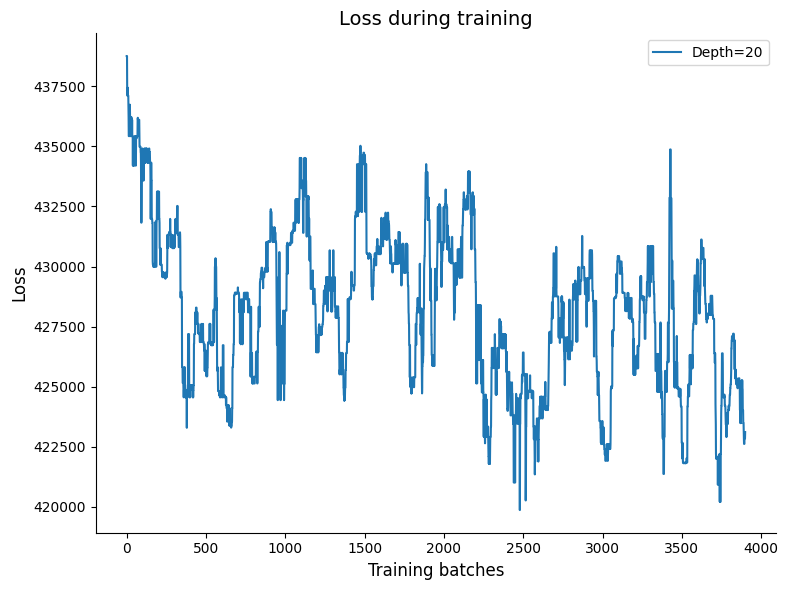

In [31]:
# Create the figure and axes
#loss not up to date, re-run training with multiple depths
layers = [20]
print(np.shape(loss_nlayers))
fig, ax = plt.subplots(figsize=(8, 6))
legds = []
# Plot the time series
ax.plot(range(len(loss_nlayers)-100),smooth(loss_nlayers,99)[50:-50])
legds.append(f"Depth={layers[0]}")

# Add legend
plt.legend(legds)

# Set x and y labels
ax.set_xlabel('Training batches', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
#ax.set_ylim(0.56e7,0.59e7)

# Set the title
ax.set_title('Loss during training', fontsize=14)

# Remove the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Set tick labels font size
ax.tick_params(axis='both', labelsize=10)

# Adjust the plot layout
plt.tight_layout()

After this first training round, I further trained the network for a total of 2300 epochs. Saving intermediate checkpoints. Let's check the change in loss both in the training and validation sets.

In [49]:
#create validation dataset
valset = GenerateData(data_oxyhb,data_oxyhbabs,data_hb,data_hbabs,data_ACh,data_ACh_spec,
                        data_Emission,data_dark_spectra,data_shot_spectra,indval_signals,indval_noise)

In [ ]:
#function to get the MSE from batches of data
def MSE_model(net, data, criterion, batch_size=10,epochs=1):
  """Function calculate MSE of a model on batches of data
      Inputs:
          net: network to train
          batch_size: size of the mini-batch used in the SGD optimization
          epochs: number of epochs
          printr: boolean to determine whether running loss is displayed during execution
          save_loss: boolean used to indicate wheter to store information about the running loss"""


  loader = DataLoader(data,batch_size=batch_size)

  losses = []
  epoch=0

  while epoch <epochs:
    for i, (clean,noise) in enumerate(loader):
      if i%100==0:
        epoch+=1
      #the sample is the sum of the clean and noise components
      sample = clean+noise
      #print((i,epoch))

      #compute network output
      outputs=net(sample)

      #calculate loss
      loss = criterion(outputs, noise)/torch.std(noise)
      losses.append(loss.item())

      # Detach unnecessary tensors and move to CPU
      # clean.detach().cpu()
      # noise_dark.detach().cpu()
      # noise_shot.detach().cpu()
      # noisex.detach().cpu()
      # sample.detach().cpu()
      # outputs.detach().cpu()
      # noise.detach().cpu()

      # # Clear GPU memory
      # del clean, noise_dark, noise_shot, noisex, sample, outputs, noise

  mean_losses = np.mean(np.array(losses))
  std_losses = np.std(np.array(losses))

  return mean_losses, std_losses


In [ ]:
#net = load_model(f"/content/drive/MyDrive/Projects/DeepDenoise/models/DnCNN_absoluteF_depth20_900epochs_expanded_200.pth",20)
#net = load_model(f"/content/drive/MyDrive/Projects/DeepDenoise/models/DnCNN_absoluteF_depth20_1300epochs.pth",20)
meanMSE_val,stdMSE_val = MSE_model(net,valset,criterion,10,5)
#meanMSE_train,stdMSE_train = MSE_model(net,trainset,criterion,10,5)

In [ ]:
print((meanMSE_val, stdMSE_val))
#print((meanMSE_train, stdMSE_train))

(261662.66846875, 36733.35594573332)


In [ ]:
#list of training epochs for each model checkpoint
checkpoints_epochs = list(range(200,1600,200))
#checkpoints_epochs.extend(range(500,2500,200))

mean_MSE_train = []
std_MSE_train = []

mean_MSE_test = []
std_MSE_test = []
for checkpoints in checkpoints_epochs:
  print(checkpoints)
  net = load_model(f"/content/drive/MyDrive/Projects/DeepDenoise/models/DnCNN_absoluteF_depth20_900epochs_expanded_{checkpoints}.pth",20)
  meanMSE,stdMSE = MSE_model(net,trainset,criterion,10,5)
  mean_MSE_train.append(meanMSE)
  std_MSE_train.append(stdMSE)

  meanMSE,stdMSE = MSE_model(net,valset,criterion,10,5)
  mean_MSE_test.append(meanMSE)
  std_MSE_test.append(stdMSE)

200
400
600
800
1000
1200
1400


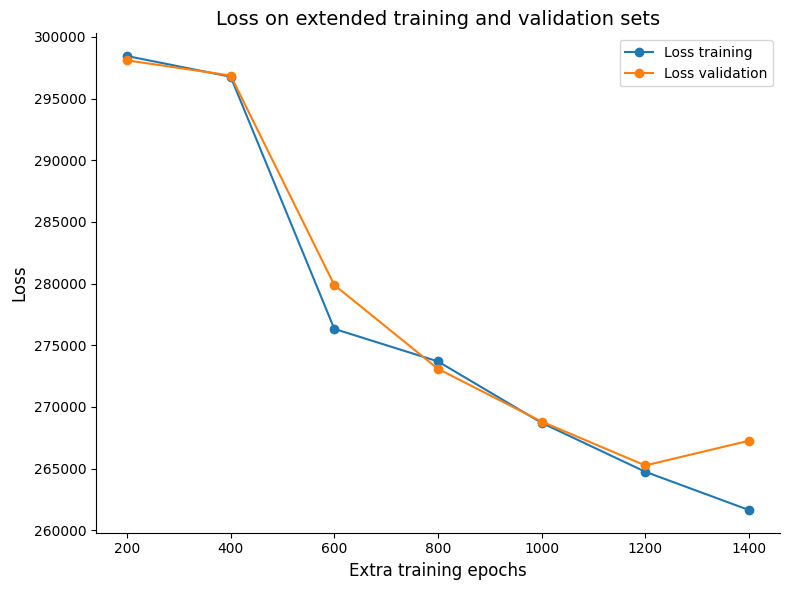

In [ ]:
figure,ax = plt.subplots(figsize=(8,6))

#ax.errorbar(checkpoints_epochs, mean_MSE_train, yerr=std_MSE_train, capsize=4)
ax.plot(checkpoints_epochs, mean_MSE_train, '-o')

#ax.errorbar(checkpoints_epochs, mean_MSE_test, yerr=std_MSE_test, capsize=4)
ax.plot(checkpoints_epochs, mean_MSE_test, '-o')

ax.legend(['Loss training','Loss validation'])

# Set x and y labels
ax.set_xlabel('Extra training epochs', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)

# Set the title
ax.set_title('Loss on extended training and validation sets', fontsize=14)

# Remove the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Set tick labels font size
ax.tick_params(axis='both', labelsize=10)

# Adjust the plot layout
plt.tight_layout()

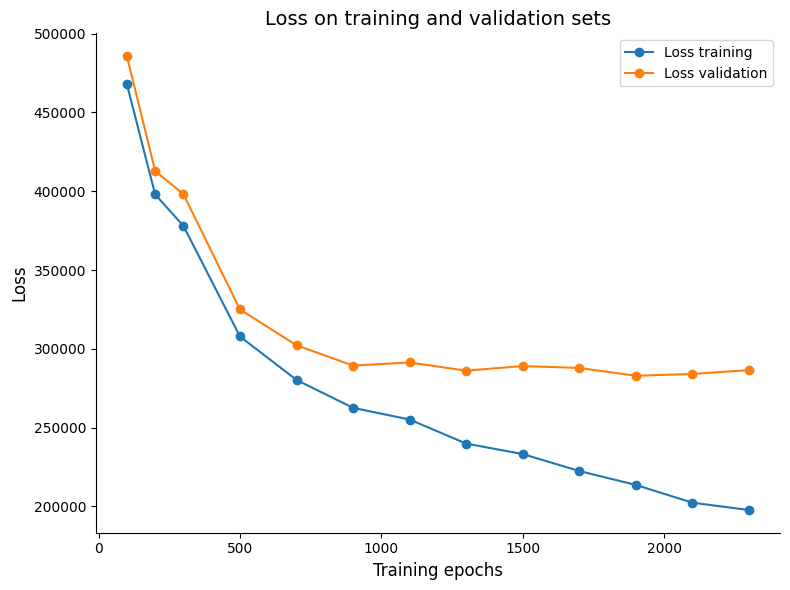

In [ ]:
figure,ax = plt.subplots(figsize=(8,6))

#ax.errorbar(checkpoints_epochs, mean_MSE_train, yerr=std_MSE_train, capsize=4)
ax.plot(checkpoints_epochs, mean_MSE_train, '-o')

#ax.errorbar(checkpoints_epochs, mean_MSE_test, yerr=std_MSE_test, capsize=4)
ax.plot(checkpoints_epochs, mean_MSE_test, '-o')

ax.legend(['Loss training','Loss validation'])

# Set x and y labels
ax.set_xlabel('Training epochs', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)

# Set the title
ax.set_title('Loss on training and validation sets', fontsize=14)

# Remove the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Set tick labels font size
ax.tick_params(axis='both', labelsize=10)

# Adjust the plot layout
plt.tight_layout()

In [ ]:
 # Calculate the mean and confidence intervals
mean_values = np.mean(loss_nlayers_all[:-5000,:], axis=0)
std_values = np.std(loss_nlayers_all[:-5000,:], axis=0)
confidence_intervals = 1.96 * (std_values / np.sqrt(5000))  # Assuming 95% confidence interval

# Plot the bar plot
plt.bar(legds, mean_values-330000, yerr=confidence_intervals, capsize=4,bottom=330000)
plt.show()

NameError: ignored

Start training, run until no noticeable decrease in loss is observed for 100 epochs.

In [ ]:
#load model checkpoint if needed
net = load_model('/content/drive/MyDrive/Projects/DeepDenoise/models/DnCNN_absoluteF_depth20_300epochs_2000.pth',20)

In [ ]:
#train
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.95)
loss_baseline = trainNet(net,train_clean,train_dark,train_shot,train_ex,optimizer,criterion,batch_size=10,epochs=50,printr=True,save_loss=True)

In [ ]:
print(np.mean(loss_baseline))
print(np.std(loss_baseline))

245439.384215625
26598.010785838313


In [ ]:
print(np.mean(loss_nlayers2[-5000:]))
print(np.std(loss_nlayers2[-5000:]))

199437.95489375
21970.644706836207


NameError: ignored

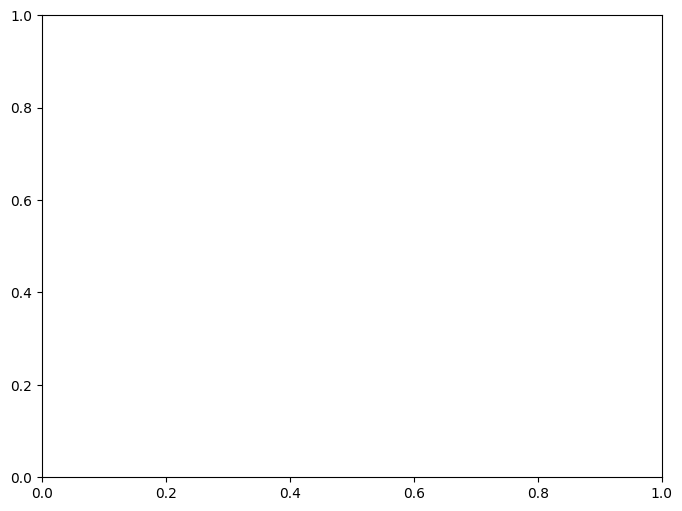

In [ ]:
#plot loss
#function to smooth the data
def smooth(data, window_length=5):
    window = np.ones(window_length) / window_length
    smoothed_data = np.convolve(data, window, mode='same')
    return smoothed_data

    return smoothed_data

# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the time series
ax.plot(range(len(loss_decay[50:-50])),smooth(loss_decay,100)[50:-50], color='#D2B48C', linewidth=2)

# Set x and y labels
ax.set_xlabel('Training instances', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)

# Set the title
ax.set_title('Loss during training', fontsize=14)

# Set grid lines
ax.grid(True, linestyle='--', linewidth=0.5)

# Remove the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Remove the grid
ax.grid(False)

# Set tick labels font size
ax.tick_params(axis='both', labelsize=10)

# Adjust the plot layout
plt.tight_layout()

#plt.plot(range(len(loss_decay[50:-50])),smooth(loss_decay,100)[50:-50])
#plt.show()

In [ ]:
#save model checkpoint
SaveCheckpoint('/content/drive/MyDrive/Projects/Data/DeepDenoise/DnCNN_absoluteF_depth17_test.pth')

In [ ]:
#load model checkpoint if needed
net = load_model('/content/drive/MyDrive/Projects/DeepDenoise/models/DnCNN_absoluteF_rescalednoise3.pth',17)

## Test CNN denoising
Next, we check the performance of the model. Since the approach to generate training data can generate a huge number of training instances (or infinite if we consider that in each batch, noise is randomly scaled) I opted to use the same strategy to generate "validation instances", as those would allways constitute new unseen data. I present further model testing in the "Testing" notebook.

Make a function to generate and run model inference in "validation" instances.

In [30]:
def testNet(net, data, batch_size=1):
    """Test function"""

    #net = net.float()
    #net.to(dev)

    loader = iter(DataLoader(data,batch_size=batch_size))

    (clean,noise) = next(loader)
    #for i, (clean,noise_dark,noise_shot,noisex) in enumerate(zip(cleanloader,noisedarkloader,noiseshotloader,noisexloader)):

    sample = clean+noise

    #compute network output
    outputs=net(sample)

    return sample, outputs, noise


### Generate instances of noisy, denoised and clean data

In [31]:
from scipy.ndimage import gaussian_filter

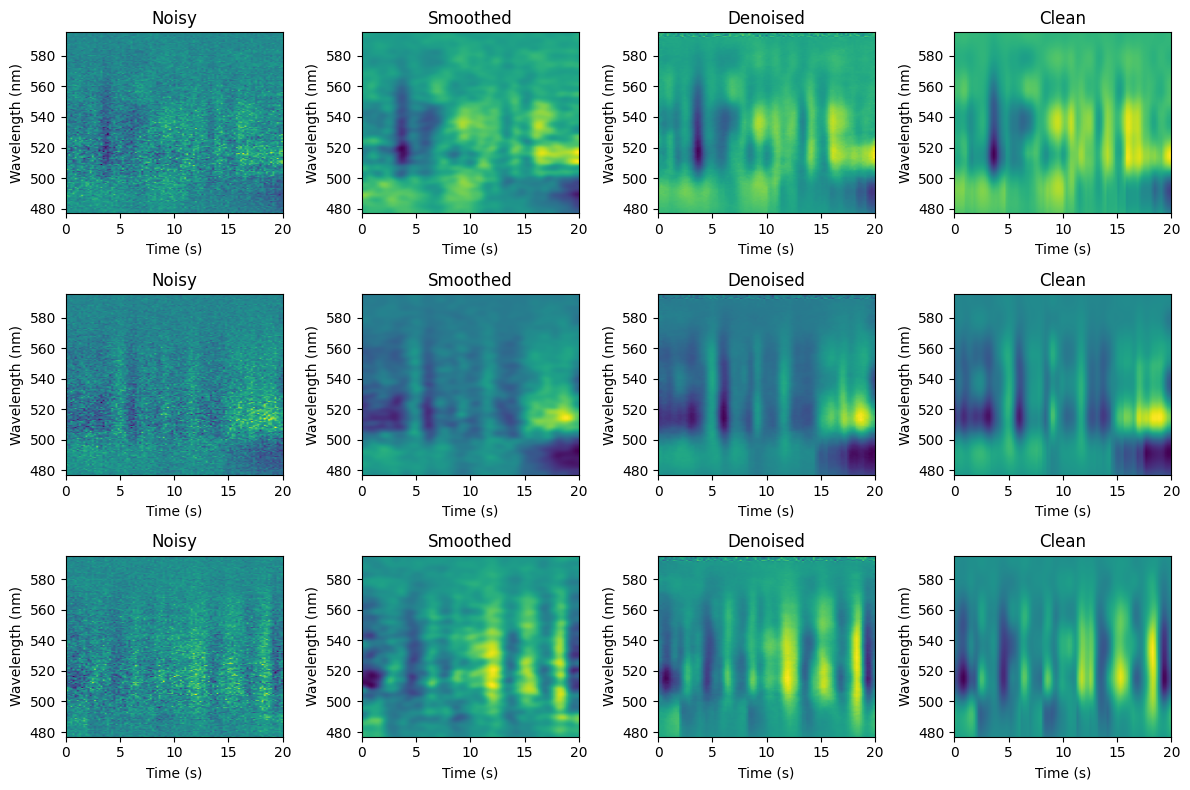

In [50]:
fig, axs = plt.subplots(3, 4, figsize=(12, 8))

wavelength = np.arange(476.924,595.404,0.7846)
time = np.arange(0,20.2,0.2)
# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.4,wspace=0.4)

axis_lims = [time[0],time[-1],wavelength[0], wavelength[-1]]

for i in range(3):
  netin, netout, target = testNet(net,valset)

  #send data to cpu and transform to plot
  noisy = np.apply_along_axis(lambda x: x-np.mean(x), 1, netin.squeeze().cpu().T)
  denoised = np.apply_along_axis(lambda x: x-np.mean(x), 1, netin.squeeze().cpu().T-netout.squeeze().detach().cpu().T)
  clean = np.apply_along_axis(lambda x: x-np.mean(x), 1, netin.squeeze().cpu().T-target.squeeze().cpu().T)

  netinsm = gaussian_filter(netin.cpu().squeeze(),sigma=(2,2))
  smoothed = np.apply_along_axis(lambda x: x-np.mean(x), 1, netinsm.T)

  # Plot clean, noise, and sample
  axs[i, 0].imshow(np.flipud(noisy), aspect='auto', cmap='viridis',extent=axis_lims)
  axs[i, 0].set_ylabel("Wavelength (nm)")
  axs[i, 0].set_xlabel("Time (s)")
  axs[i, 0].set_title("Noisy")

  axs[i, 1].imshow(np.flipud(smoothed), aspect='auto', cmap='viridis',extent=axis_lims)
  axs[i, 1].set_ylabel("Wavelength (nm)")
  axs[i, 1].set_xlabel("Time (s)")
  axs[i, 1].set_title("Smoothed")

  axs[i, 2].imshow(np.flipud(denoised), aspect='auto', cmap='viridis',extent=axis_lims)
  axs[i, 2].set_ylabel("Wavelength (nm)")
  axs[i, 2].set_xlabel("Time (s)")
  axs[i, 2].set_title("Denoised")

  axs[i, 3].imshow(np.flipud(clean), aspect='auto', cmap='viridis',extent=axis_lims)
  axs[i, 3].set_ylabel("Wavelength (nm)")
  axs[i, 3].set_xlabel("Time (s)")
  axs[i, 3].set_title("Clean")

plt.tight_layout()
plt.show()

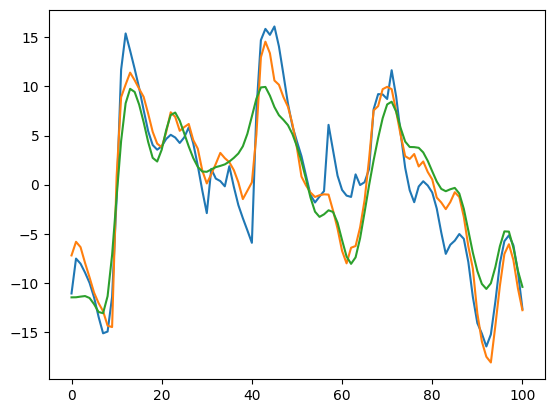

In [51]:
plt.plot(range(101),-clean[10,:])
plt.plot(range(101),-denoised[10,:])
#plt.plot(range(101),-noisy[10,:])
plt.plot(range(101),-smoothed[10,:])

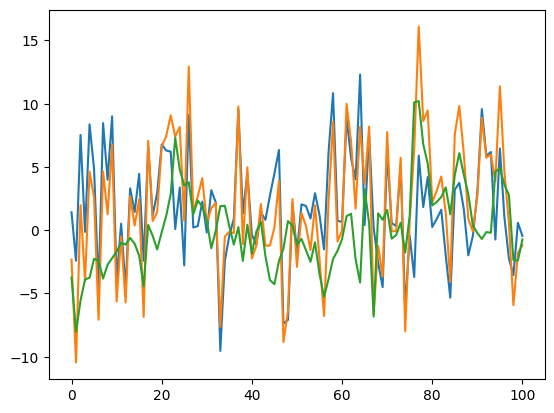

In [47]:
plt.plot(range(101),netout[:,:,:,10].squeeze().cpu().detach().numpy())
plt.plot(range(101),target[:,:,:,10].squeeze().cpu().detach().numpy())
plt.plot(range(101),target[:,:,:,10].squeeze().cpu().detach().numpy()-netout[:,:,:,10].squeeze().cpu().detach().numpy())
plt.show()